# Drive & Setting

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
#from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
#from tensorflow.keras import initializers
#from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

#from pkl import store_data, load_data
#from functions.compressor import compress
from functions.compressor_param import compress_2
from functions.mapping import sub2ind3d, ind2sub, take_action
from functions.policy_functions import policy_evaluation, policy_improvement, policy_iteration, policy_optim, value_iteration


import random
from collections import defaultdict

import time



print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-05-23 15:26:51.953906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


In [27]:
#load from npy
cta30_partitioned = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_partitioned.csv')
CTA30_partitioned = [cta30_partitioned]
df = pd.read_csv(CTA30_partitioned[0])

cluster_group_df = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/cluster_group_df.csv')
cluster_group_df = pd.read_csv(cluster_group_df)

f_min = df['F_M_FDBK_00'].min()
f_max = df['F_M_FDBK_00'].max()

mr_8_path = os.path.join(PROJECT_PATH, 'MDP_data/Cluster_8/mr_Cluster_8.npy')
mr_8 = np.load(mr_8_path)
mr_10_path = os.path.join(PROJECT_PATH, 'MDP_data/Cluster_10/mr_Cluster_10.npy')
mr_10 = np.load(mr_10_path)
mr_15_path = os.path.join(PROJECT_PATH, 'MDP_data/Cluster_15/mr_Cluster_15.npy')
mr_15 = np.load(mr_15_path)
mr_22_path = os.path.join(PROJECT_PATH, 'MDP_data/Cluster_22/mr_Cluster_22.npy')
mr_22 = np.load(mr_22_path)
mr_30_path = os.path.join(PROJECT_PATH, 'MDP_data/Cluster_30/mr_Cluster_30.npy')
mr_30 = np.load(mr_30_path)


R_cluster_8 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_8/R_Cluster_8.npy'))
R_cluster_10 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_10/R_Cluster_10.npy'))
R_cluster_15 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_15/R_Cluster_15.npy'))
R_cluster_22 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_22/R_Cluster_22.npy'))
R_cluster_30 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_30/R_Cluster_30.npy'))

T_cluster_8 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_8/T_Cluster_8.npy'))
T_cluster_10 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_10/T_Cluster_10.npy'))
T_cluster_15 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_15/T_Cluster_15.npy'))
T_cluster_22 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_22/T_Cluster_22.npy'))
T_cluster_30 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_30/T_Cluster_30.npy'))

actions = np.load(os.path.join(PROJECT_PATH, 'MDP_data/actions.npy'))

T_group = [T_cluster_8, T_cluster_10, T_cluster_15, T_cluster_22, T_cluster_30]
R_group = [R_cluster_8, R_cluster_10, R_cluster_15, R_cluster_22, R_cluster_30]
mr_group = [mr_8, mr_10, mr_15, mr_22, mr_30]


policy_0_path = os.path.join(PROJECT_PATH, 'df_policy_new/net_0/nn_net_0.csv')
policy_0 = pd.read_csv(policy_0_path)
policy_1_path = os.path.join(PROJECT_PATH, 'df_policy_new/net_1/nn_net_1.csv')
policy_1 = pd.read_csv(policy_1_path)
policy_2_path = os.path.join(PROJECT_PATH, 'df_policy_new/net_2/nn_net_2.csv')
policy_2 = pd.read_csv(policy_2_path)
policy_3_path = os.path.join(PROJECT_PATH, 'df_policy_new/net_3/nn_net_3.csv')
policy_3 = pd.read_csv(policy_3_path)

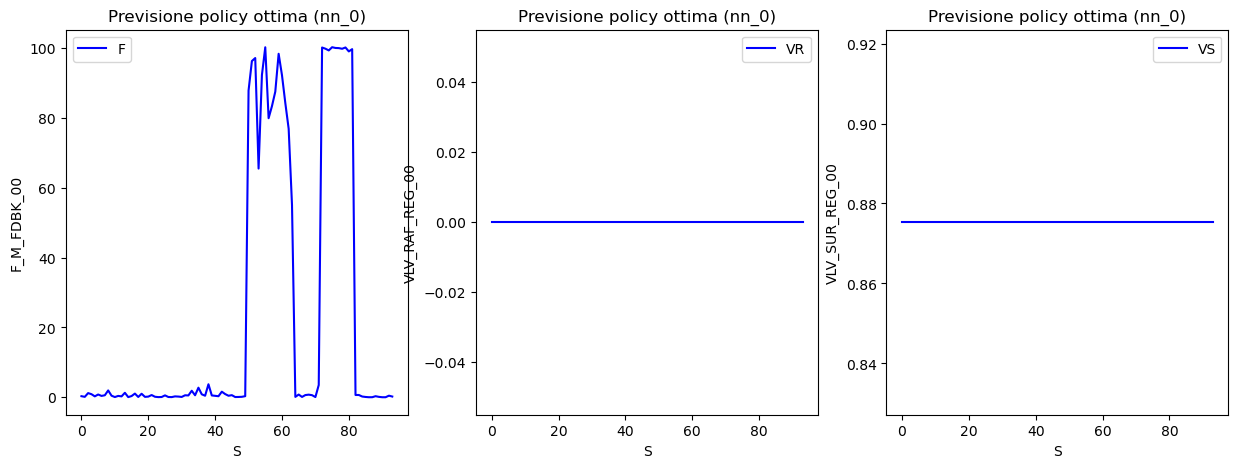

In [18]:
f_actions = []
vr_actions = []
vs_actions = []

for i in range(len(policy_0)):
    x = []
    xf = policy_0.loc[i, 'a1']
    xv = policy_0.loc[i, 'a2']
    x.append(xf)
    x.append(xv)
    f, vr, vs = take_action(x, f_min, f_max)
    f_actions.append(f)
    vr_actions.append(vr)
    vs_actions.append(vs)

# Crea una figura e tre assi
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Disegna il grafico per f_actions sull'asse 1
ax1.plot(f_actions, label='F', color='blue')
ax1.set_xlabel('S')
ax1.set_ylabel('F_M_FDBK_00')
ax1.set_title('Previsione policy ottima (nn_0)')
ax1.legend()

# Disegna il grafico per vr_actions sull'asse 2
ax2.plot(vr_actions, label='VR', color='blue')
ax2.set_xlabel('S')
ax2.set_ylabel('VLV_RAF_REG_00')
ax2.set_title('Previsione policy ottima (nn_0)')
ax2.legend()

# Disegna il grafico per vs_actions sull'asse 3
ax3.plot(vs_actions, label='VS', color='blue')
ax3.set_xlabel('S')
ax3.set_ylabel('VLV_SUR_REG_00')
ax3.set_title('Previsione policy ottima (nn_0)')
ax3.legend()

# Mostra la figura con i tre grafici
plt.show()

In [30]:
df_test = df[['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00']]

df_confronto = pd.DataFrame()
for i in range(policy_0.shape[0]):
    
    state = policy_0.loc[i, 's'].astype(int)
    df_confronto.loc[i,:] = df_test.loc[state,:]

    

ValueError: Must have equal len keys and value when setting with an iterable

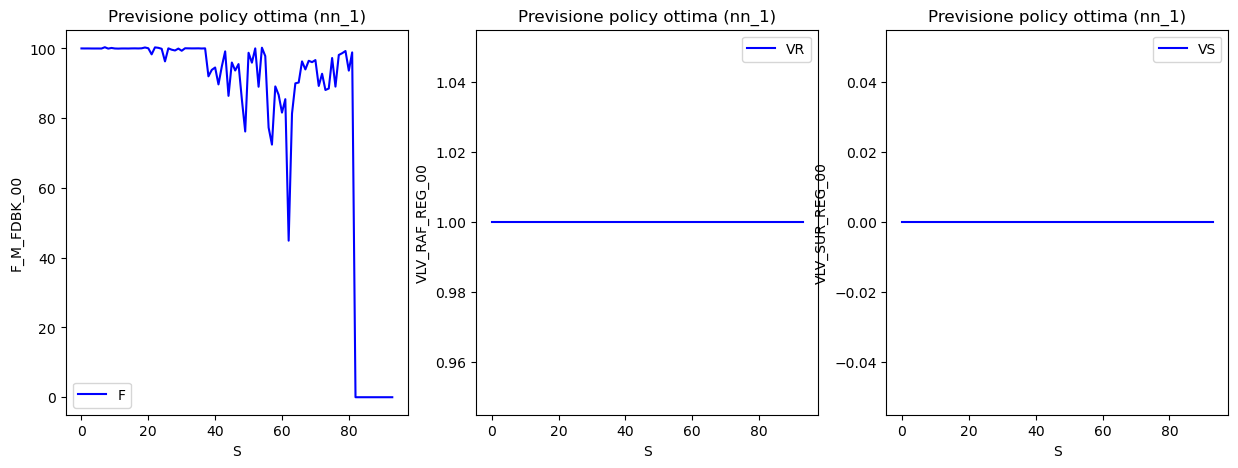

In [25]:
f_actions = []
vr_actions = []
vs_actions = []

for i in range(len(policy_1)):
    x = []
    xf = policy_1.loc[i, 'a1']
    xv = policy_1.loc[i, 'a2']
    x.append(xf)
    x.append(xv)
    f, vr, vs = take_action(x, f_min, f_max)
    f_actions.append(f)
    vr_actions.append(vr)
    vs_actions.append(vs)

# Crea una figura e tre assi
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Disegna il grafico per f_actions sull'asse 1
ax1.plot(f_actions, label='F', color='blue')
ax1.set_xlabel('S')
ax1.set_ylabel('F_M_FDBK_00')
ax1.set_title('Previsione policy ottima (nn_1)')
ax1.legend()

# Disegna il grafico per vr_actions sull'asse 2
ax2.plot(vr_actions, label='VR', color='blue')
ax2.set_xlabel('S')
ax2.set_ylabel('VLV_RAF_REG_00')
ax2.set_title('Previsione policy ottima (nn_1)')
ax2.legend()

# Disegna il grafico per vs_actions sull'asse 3
ax3.plot(vs_actions, label='VS', color='blue')
ax3.set_xlabel('S')
ax3.set_ylabel('VLV_SUR_REG_00')
ax3.set_title('Previsione policy ottima (nn_1)')
ax3.legend()

# Mostra la figura con i tre grafici
plt.show()

p_eval convergenza raggiunta
p_eval convergenza raggiunta
p_iteration convergenza raggiunta
policy:  [[1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]
value:  [-4.22496359e-03 -1.88782069e+00 -5.24500384e-01 -1.36947329e+00
 -1.78132230e+00 -3.83183757e-03 -1.42833071e-02 -1.44291523e+01]


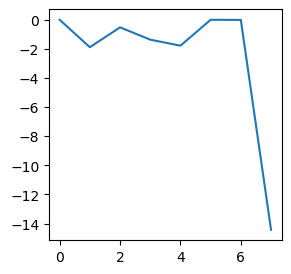

p_eval convergenza raggiunta
p_eval convergenza raggiunta
p_iteration convergenza raggiunta
policy:  [[2.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]
value:  [-1.48091626e-02 -1.43190036e+01 -3.83183757e-03 -1.40237509e-02
 -1.88897512e+00 -4.12490584e-03 -1.09711703e-01 -5.06819540e-01
 -3.99370480e+00 -5.26614926e+00]


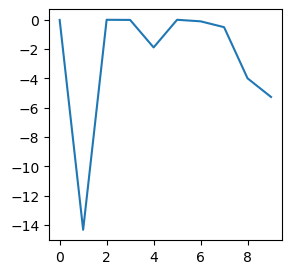

p_eval convergenza raggiunta
p_eval convergenza raggiunta
p_iteration convergenza raggiunta
policy:  [[0.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [2.]]
value:  [-2.60188436e+00 -9.34606023e-03 -3.83183757e-03 -3.28185141e-01
 -2.15395432e-02 -2.79761296e+00 -1.11508014e-01 -1.89450699e+01
 -4.12490584e-03 -8.97219072e+00 -6.67593435e+00 -5.72357008e-02
 -4.40441520e+00 -2.85841429e-01 -6.39982807e-01]


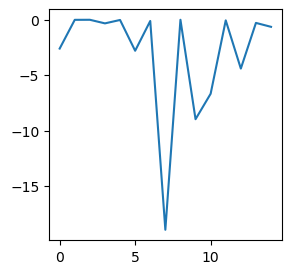

p_eval convergenza raggiunta
p_eval convergenza raggiunta
p_iteration convergenza raggiunta
policy:  [[1.]
 [1.]
 [2.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [2.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]
value:  [-5.72378747e-02 -4.12492903e-03 -2.22831360e-02 -4.14852841e-01
 -8.26171975e-02 -3.83183757e-03 -4.31105867e-04 -7.48376119e+00
 -2.42824783e-03 -2.65640003e+00 -1.80843839e+01 -1.14229237e+00
 -1.23368692e+00 -3.24080125e-01 -1.69293600e-02 -6.67570524e+00
 -6.49449901e-01 -1.59299042e-02 -6.12817579e-01 -1.75869601e+01
 -4.44508637e-02 -6.45739661e+00]


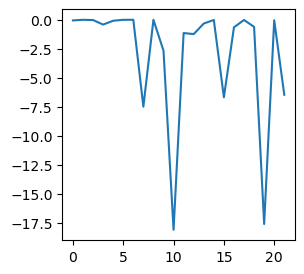

p_eval convergenza raggiunta
p_eval convergenza raggiunta
p_iteration convergenza raggiunta
policy:  [[1.]
 [2.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [2.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]
value:  [-2.59903568e-03 -1.68966082e-02 -1.68467041e-02 -5.85931483e-02
 -5.95576194e-02 -1.59299042e-02 -2.73520881e-03 -6.06009586e-01
 -7.11482409e+00 -1.38823736e+00 -6.67570524e+00 -1.92720477e+01
 -2.33900617e+00 -2.28623551e+00 -7.95795578e+00 -1.64965780e-01
 -9.39439597e-01 -4.31105867e-04 -4.69202885e-05 -4.44508637e-02
 -6.12651570e-01 -1.74363307e+01 -2.46356669e-02 -5.75230044e-02
 -1.13948471e+01 -1.79780921e+00 -1.15527786e-01 -1.72122294e+01
 -2.80465873e-04 -7.22559564e+00]


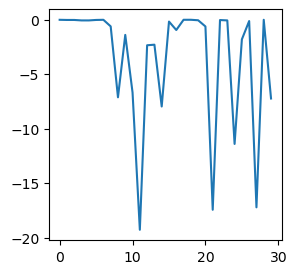

In [23]:
for T in T_group:
    policy, value = policy_iteration(T=T, R=R_group[T_group.index(T)], gamma=0.99)
    print("policy: ", policy)
    print("value: ", value)
    #plot the best action for each state
    #best_action = np.argmax(R_group[T_group.index(T)], axis=0)
    plt.figure(figsize=(3,3))
    #plt.plot(-mr_group[T_group.index(T)])
    plt.plot(value)
    plt.show()